# Assignment 1

## Programming Questions (Question 4: 45 points, Question 5, 30 points)

4.Load mnist dataset. Normalize the data. Split the data into training, validation and testing set. 

Build a CNN network with convolution layers, pooling layers to classify the number.  

Plot the training loss and validation loss as a function of epochs.

Plot the both training accuracy and validation accuracy as a function of epochs. 

Print the testing accuracy.

**Note:** Initial code has been provided to import the necessary packages and load the dataset. Now that we have introduced PyTorch programming, you should use it to solve the programming problems in this assignment.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
training_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testing_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
training_set, validation_set = utils.data.random_split(training_data, [50000, 10000])

In [3]:
batch_size = 4
trainloader = DataLoader(training_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = DataLoader(validation_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = DataLoader(testing_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 5)
        self.fc1 = nn.Linear(6 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


mnist_network = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_network.parameters(), lr=0.001, momentum=0.9)

In [5]:
epoch_count = []
epoch_training_loss = []
epoch_training_accuracy = []
epoch_validation_loss = []
epoch_validation_accuracy = []

for epoch in range(2):  # loop over the dataset multiple times
    epoch_count.append(epoch+1)
    running_loss = 0.0
    total_loss = 0.0
    total = 0
    correct = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mnist_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calc training accuracy and loss
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    epoch_training_loss.append(total_loss / total)
    epoch_training_accuracy.append(correct / total)

    with torch.no_grad():
        total_loss = 0.0
        total = 0
        correct = 0
        for data in valloader:
            inputs, labels = data
            # calculate outputs by running images through the network
            outputs = mnist_network(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_validation_loss.append(total_loss / total)
    epoch_validation_accuracy.append(correct / total)
    

print('Finished Training')

[1,  2000] loss: 1.301
[1,  4000] loss: 0.292
[1,  6000] loss: 0.208
[1,  8000] loss: 0.175
[1, 10000] loss: 0.141
[1, 12000] loss: 0.129
[2,  2000] loss: 0.103
[2,  4000] loss: 0.100
[2,  6000] loss: 0.101
[2,  8000] loss: 0.097
[2, 10000] loss: 0.092
[2, 12000] loss: 0.100
Finished Training


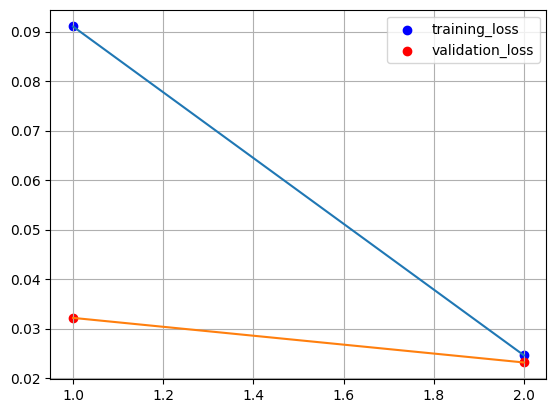

In [8]:
fig, ax = plt.subplots()
ax.scatter(epoch_count, epoch_training_loss, c='blue', label='training_loss')
ax.scatter(epoch_count, epoch_validation_loss, c='red', label='validation_loss')

training_function = np.polyfit(epoch_count, epoch_training_loss, 1)
training_trendline = np.poly1d(training_function)
plt.plot(epoch_count, training_trendline(epoch_count))

validation_function = np.polyfit(epoch_count, epoch_validation_loss, 1)
validation_trendline = np.poly1d(validation_function)
plt.plot(epoch_count, validation_trendline(epoch_count))

ax.legend()
ax.grid(True)

plt.show()

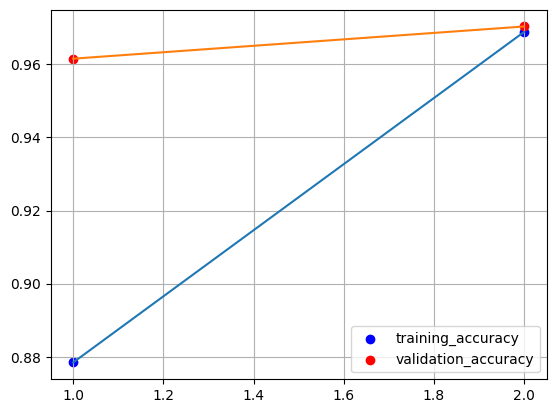

In [9]:
fig, ax = plt.subplots()
ax.scatter(epoch_count, epoch_training_accuracy, c='blue', label='training_accuracy')
ax.scatter(epoch_count, epoch_validation_accuracy, c='red', label='validation_accuracy')

training_function = np.polyfit(epoch_count, epoch_training_accuracy, 1)
training_trendline = np.poly1d(training_function)
plt.plot(epoch_count, training_trendline(epoch_count))

validation_function = np.polyfit(epoch_count, epoch_validation_accuracy, 1)
validation_trendline = np.poly1d(validation_function)
plt.plot(epoch_count, validation_trendline(epoch_count))

ax.legend()
ax.grid(True)

plt.show()

In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = mnist_network(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Testing Accuracy: {correct / total}')

Testing Accuracy: 0.975


5.Load cifar10 dataset. Build a CNN network with convolution layers to classify the images. 

Print the accuracy.  

Tune the hyper parameters if needed to get a good accuracy. 



In [11]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
batch_size = 4
trainloader = DataLoader(training_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = DataLoader(testing_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cifar_network = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_network.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cifar_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}') 
            running_loss = 0.0   

print('Finished Training')

[1,  2000] loss: 2.237
[1,  4000] loss: 1.975
[1,  6000] loss: 1.816
[1,  8000] loss: 1.746
[1, 10000] loss: 1.654
[1, 12000] loss: 1.636
[2,  2000] loss: 1.572
[2,  4000] loss: 1.549
[2,  6000] loss: 1.528
[2,  8000] loss: 1.475
[2, 10000] loss: 1.462
[2, 12000] loss: 1.402
[3,  2000] loss: 1.395
[3,  4000] loss: 1.398
[3,  6000] loss: 1.377
[3,  8000] loss: 1.373
[3, 10000] loss: 1.335
[3, 12000] loss: 1.333
[4,  2000] loss: 1.292
[4,  4000] loss: 1.310
[4,  6000] loss: 1.306
[4,  8000] loss: 1.309
[4, 10000] loss: 1.282
[4, 12000] loss: 1.271
[5,  2000] loss: 1.260
[5,  4000] loss: 1.260
[5,  6000] loss: 1.254
[5,  8000] loss: 1.232
[5, 10000] loss: 1.231
[5, 12000] loss: 1.218
[6,  2000] loss: 1.215
[6,  4000] loss: 1.197
[6,  6000] loss: 1.194
[6,  8000] loss: 1.199
[6, 10000] loss: 1.213
[6, 12000] loss: 1.191
[7,  2000] loss: 1.163
[7,  4000] loss: 1.153
[7,  6000] loss: 1.189
[7,  8000] loss: 1.155
[7, 10000] loss: 1.166
[7, 12000] loss: 1.156
[8,  2000] loss: 1.161
[8,  4000] 

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cifar_network(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Testing Accuracy: {correct / total}')

Testing Accuracy: 0.6068
